# Evolution du bruit médian en France depuis le début de la pandémie

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize
from scipy.signal import hilbert


from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"
freq_str = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"
year_ref = 2019

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)

In [3]:
tags = {
    "2020-03-17": "Lockdown 1",
    "2020-05-11": "End lockdown",
    "2020-10-30": "Lockdown 2",
    "2020-12-15": "End lockdown + Curfew 20h",
    "2020-12-25": "Christmas",
    "2021-01-01": "New Year",
    "2021-01-16": "Curfew 18h",
    "2021-03-20": "Curfew 19h",
    "2021-04-03": "Lockdown 3",
    "2021-05-03": "End of certificate",
    "2021-05-19": "Curfew 21h + Shops open",
    "2021-06-09": "Curfew 23h + Restaurants open",
    "2021-06-30": "End Curfew"
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

---
## Médiane à toutes les stations

#### Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [4]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [5]:
med_values = []
st_list = []
dCalendar = np.arange(1,577,1)
df = pd.DataFrame(columns=[freq], index=pd.date_range('2019-01-02', '2020-08-01', freq="D"))
dfcovid = pd.DataFrame(columns=[freq], index=pd.date_range(tStart, tEnd, freq="D"))

for j, st_str in enumerate(list_stations):       
    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index=pd.to_datetime(dataframe.index)
        dRMS = dataframe
    except:
        continue

    st_list = np.append(st_list, st_str)  

    ### Conversion heures locales
    dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()

    ### On garde les données dans la période temporelle qui nous intéresse
    # dRMS de référence (2019)
    mask_ref = (dRMS.index > pd.Timestamp("2019-01-01")) & (dRMS.index <= pd.Timestamp("2020-01-01"))
    dRMS_ref = dRMS.loc[mask_ref]
    submask = (dRMS_ref.index > (tStart - pd.Timedelta("365 days"))) & (dRMS_ref.index <= (tEnd - pd.Timedelta("731 days")))
    dRMS_sub = dRMS_ref.loc[submask]
    dRMS_sub.index = dRMS_sub.index + pd.offsets.DateOffset(years=1)
    dRMS_2019 = pd.concat([dRMS_ref, dRMS_sub])
    dRMS_2019_copy = dRMS_2019.copy()

    # dRMS à comparer (2020-2021)
    mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
    dRMS = dRMS.loc[mask_time]

    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "18:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    # norm = np.nanmedian(dRMS_med)
    # dRMS_med = dRMS_med/norm
    # med_values.append(dRMS_med)


    ####################################################################################
    ### Calcul des différences 2019 / COVID
    dRMS_2019 = dRMS_2019[freq].between_time("6:00", "18:00").resample("1D").median()[1:]
    dRMS_2019 = pd.merge(df,dRMS_2019, how='outer', left_index=True, right_index=True)["{}_y".format(freq)]
    dRMS_2019.name = freq
    
    dRMS_covid = dRMS[freq].between_time("6:00", "18:00").resample("1D").median()
    dRMS_covid = pd.merge(dfcovid,dRMS_covid, how='outer', left_index=True, right_index=True)["{}_y".format(freq)]
    dRMS_covid.name = freq
    
    noise_2019  = dRMS_2019.tolist()
    
    ii = 1
    # Retrait du 01/01/2019 pour se recaler sur un lundi en 2020
    del noise_2019[364]
    ii += 1

    # Retrait du 29 février qui n'existe pas en 2019 pour ne pas être décalé d'un jour calendaire
    del noise_2019[422]
    ii += 1

    noise_2019 = np.asarray(noise_2019)
    noise_covid = np.asarray(dRMS_covid[:-ii].tolist())
    # noise_covid = np.asarray(dRMS[freq].resample("1D").median()[:-ii].tolist())
    dates_diff  = dRMS.resample("1D").median()[:-ii].index
    data_diff   = (noise_covid-noise_2019)/noise_2019 * 100
    
    if np.isnan(np.nanmedian(data_diff)):
        print('Aucune donnée pour ', st_str)
        continue
        
    med_values.append(data_diff)


    if False:
        ####################################################################################
        ### Affichage des différences
        box_txt = dict(boxstyle="square",
                   facecolor='#B7C0D8',
                   edgecolor='none',
                   alpha=0.5)

        plt.figure(figsize=(15, 10))

        plt.subplot(313)
        if not np.isnan(np.nanmedian(data_diff)):
            plt.plot(dCalendar, data_diff, color="#2C598E", lw=1)
            plt.ylim(2*np.nanquantile(data_diff, 0.05), 2*np.nanquantile(data_diff, 0.95))
            plt.xlim([0, 576])
            plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
            plt.ylabel("Variations par rapport à 2019 [%]")
            plt.xlabel("Calendar days")

            for n in range(len(dates_tags)):
                delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
                t_search = delta.days
                desc_search = desc_tags[n]
                t_text = t_search - 5
                plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1
                plt.text(t_text, 1.9*np.nanquantile(data_diff, 0.05), desc_search,
                        color="#2B2B2B", fontsize="medium", rotation=90,
                        ha="center", va="bottom",
                        bbox=box_txt)   # Confinement 1


        plt.subplot(312)
        plt.plot(dRMS[freq]*1e9, color="#2C598E", lw=1)
        plt.ylim(0.5*np.nanquantile(dRMS[freq]*1e9, 0.05), 2*np.nanquantile(dRMS[freq]*1e9, 0.95))
        plt.xlim(dates[0], dates[-1])
        plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
        plt.legend(["Niveau de bruit 2020-2021 (COVID)"], loc=2)
        plt.ylabel("Déplacement RMS [nm]")

        for n in range(len(dates_tags)):
            t_search = dates_tags[n]
            desc_search = desc_tags[n]
            t_text = t_search - pd.Timedelta("5 days")
            plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1


        plt.subplot(311)
        if not np.isnan(np.nanmedian(data_diff)):
            plt.title("{} - [{}] Hz".format(st_str, freq_str))
            plt.plot(dRMS_2019_copy[freq]*1e9, color="#2C598E", lw=1)
            plt.ylim(0.5*np.nanquantile(dRMS_2019_copy[freq]*1e9, 0.05), 2*np.nanquantile(dRMS_2019_copy[freq]*1e9, 0.95))
            plt.xlim(dRMS_2019.index[0], dRMS_2019.index[-1])
            plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
            plt.legend(["Niveau de bruit 2019"], loc=2)
            plt.ylabel("Déplacement RMS [nm]")

        plt.tight_layout()

        folder = "RESULTS/FR/{}/{}Hz/ref2019".format(st_str, freq_str)
        if not os.path.exists(folder): os.makedirs(folder)
        plt.savefig("{}/ts_day.png".format(folder), dpi=300)
        plt.clf()
        plt.close()
        # plt.show()

/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Aucune donnée pour  FR.BARI.00.HHZ
Aucune donnée pour  FR.BESN.00.HHZ
Aucune donnée pour  FR.BIMF.00.HHZ
Aucune donnée pour  FR.BOUF.00.HHZ
Aucune donnée pour  FR.BRGF.00.HHZ
Aucune donnée pour  FR.BSCF.00.HHZ
Aucune donnée pour  FR.CHLF.00.HHZ
Aucune donnée pour  FR.CLEV.00.HHZ
Aucune donnée pour  FR.CLF.00.HHZ
Aucune donnée pour  FR.CRNF.00.HHZ
Aucune donnée pour  FR.CURIE.00.HHZ
Aucune donnée pour  FR.FAHY.00.HHZ
Aucune donnée pour  FR.GARF.00.HHZ
Aucune donnée pour  FR.GNEF.00.HHZ
Aucune donnée pour  FR.HELF.00.HHZ
Aucune donnée pour  FR.HRSF.00.HHZ
Aucune donnée pour  FR.OGGL.00.HHZ
Aucune donnée pour  FR.OGJA.00.HHZ
Aucune donnée pour  FR.RESF.00.HHZ
Aucune donnée pour  FR.RUFF.00.HHZ
Aucune donnée pour  FR.SROF.00.HHZ
Aucune donnée pour  FR.VILS.00.HHZ


In [6]:
print("Dimensions de la matrice :", np.shape(med_values))

Dimensions de la matrice : (107, 576)


In [7]:
nDays = 576
dates = dates[:-2]

#### Calcul de la médiane de toutes les stations

/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


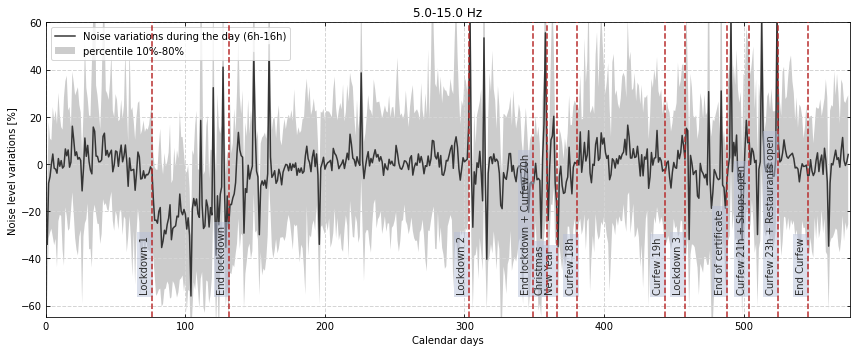

In [8]:
noise_fr = np.zeros(nDays)

for i in range(nDays):

    sublist = list()

    for j in range(np.shape(med_values)[0]):
        sublist = np.append(sublist, med_values[j][i])

    noise_fr[i] = np.nanmedian(sublist)
    
color = "#353535"
fig = plt.figure(figsize=(12, 5))
plt.tick_params(direction="in", which="both", top=True, right=True)
plt.plot(dCalendar, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations during the day (6h-16h)")
plt.ylim(3.5 * np.nanquantile(noise_fr, 0.05), 5 * np.nanquantile(noise_fr, 0.95))
plt.xlim([0, 576])
plt.xlabel("Calendar days")
plt.ylabel("Noise level variations [%]")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
    t_search = delta.days
    desc_search = desc_tags[n]
    t_text = t_search - 5
    plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1
    plt.text(t_text, 1.9*np.nanquantile(data_diff, 0.05), desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

# med_var = np.zeros(np.shape(med_values))

# for i in range(np.shape(med_var)[0]):
#     sub_list = med_values[i][:]    
#     med_var[i][:] = (sub_list - np.nanmedian(sub_list))/np.nanmedian(sub_list) * 100
    
med_var = med_values.copy()
    
perc_i = list()  # 5%
perc_f = list()  # 80%

for ii in range(np.shape(med_var)[1]):
    sublist = list()
    for i in range(np.shape(med_var)[0]):
        sublist = np.append(sublist, med_var[i][ii])

    perc_i = np.append(perc_i, np.nanquantile(sublist, 0.1))
    perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))
    
plt.fill_between(dCalendar, perc_i, perc_f,alpha=.25, label="percentile 10%-80%", color=color, lw=0)    
plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-65, 60)
plt.legend(loc=2)
plt.title("{} Hz".format(freq_str))
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz/ref2019".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_day.png".format(folder), dpi=150)
plt.show()

In [9]:
def enveloppe(x, f):
    lmin = (np.diff(np.sign(np.diff(f))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(f))) < 0).nonzero()[0] + 1 

    idx_down = lmin[[i+np.argmin(f[lmin[i:i+1]]) for i in range(0,len(lmin), 1)]]
    idx_up = lmax[[i+np.argmax(f[lmax[i:i+1]]) for i in range(0,len(lmax), 1)]]
    
    env_down = np.interp(x, x[idx_down], f[idx_down])
    env_up = np.interp(x, x[idx_up], f[idx_up])
    
    return env_down, env_up

In [10]:
env_up_matrix = np.zeros(np.shape(med_var))
env_down_matrix = np.zeros(np.shape(med_var))

for i in range(np.shape(med_var)[0]):
    sub_list = med_var[i][:]
    if np.isnan(np.nanmedian(sub_list)):
        print('erreur...')
        continue
    env_down, env_up = enveloppe(dCalendar, sub_list)
    env_up_matrix[i][:] = env_up
    env_down_matrix[i][:] = env_down

/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_11349/3829268489.py:78: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dCalendar, st_list_bis, array2D_bis)


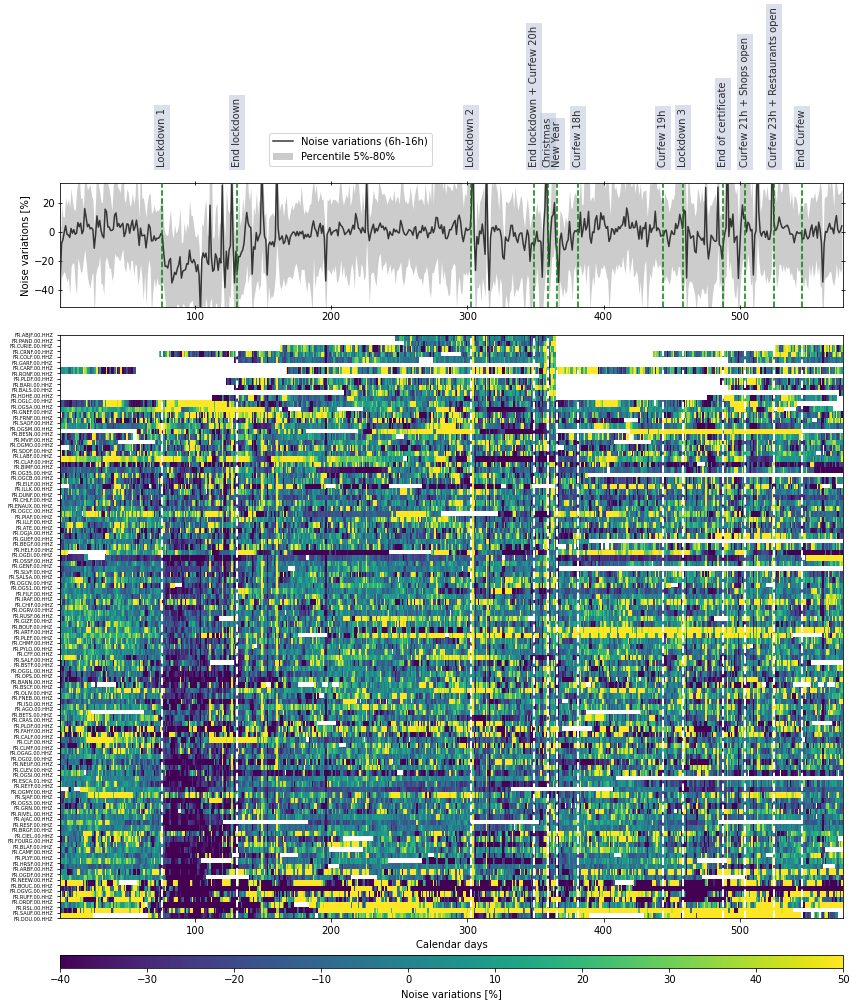

In [11]:
# Signal à afficher
signal_choice = "all" # "all", "env_up", "env_down"

# for signal_choice in ["all", "env_up", "env_down"]:

if signal_choice == "all":
    filename_suffix = ""
    cbar_lim = (-40, 50)

if signal_choice == "env_up":
    filename_suffix = "_envUP"
    cbar_lim = (-10, 150)

if signal_choice == "env_down":
    filename_suffix = "_envDOWN"
    cbar_lim = (-30, 15)



fig = plt.figure(figsize=(12, 15))
grid = plt.GridSpec(30, 1)

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

### MEDIANE
plt.subplot(grid[:5])
plt.tick_params(direction="inout", which="both", top=True, right=True)
plt.xlim([dCalendar[0], dCalendar[-1]])
plt.ylabel("Noise variations [%]")
plt.plot(dCalendar, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations (6h-16h)")
if signal_choice == "env_up":
    plt.plot(dCalendar, enveloppe(dCalendar, noise_fr)[1], color="#D32727", label="Upper Envelope", lw=1)
if signal_choice == "env_down":
    plt.plot(dCalendar, enveloppe(dCalendar, noise_fr)[0], color="#D32727", label="Lower Envelope", lw=1)
plt.fill_between(dCalendar, perc_i, perc_f,alpha=.25, label="Percentile 5%-80%", color=color, lw=0)    
plt.ylim(2*np.nanquantile(noise_fr, 0.05), 2.5*np.nanquantile(noise_fr, 0.95))
plt.legend(loc=2, bbox_to_anchor=(0.26, 1.45))
# plt.xticks([])

for n in range(len(dates_tags)):
    delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
    t_search = delta.days
    desc_search = desc_tags[n]
    t_text = t_search
    plt.axvline(t_search, ls="--", lw=1.5, color="green", zorder=10)   # Confinement 1
    plt.text(t_text, 45, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

# ### MEDIANE COLORMESH
# plt.subplot(grid[5])
# plt.tick_params(direction="inout", which="both", top=True, right=True)
if signal_choice == "all":      array1D = noise_fr
if signal_choice == "env_up":   array1D = enveloppe(dates, noise_fr)[1]
if signal_choice == "env_down": array1D = enveloppe(dates, noise_fr)[0]
# plt.pcolormesh(dates, [".", ""], [array1D, array1D])
# plt.yticks([])
# plt.xticks([])
# # plt.clim(cbar_lim)
# plt.clim(np.quantile(array1D, 0.05), np.quantile(array1D, 0.95))


### DETAILS
plt.subplot(grid[5:])
if signal_choice == "all":      array2D = med_var
if signal_choice == "env_up":   array2D = env_up_matrix
if signal_choice == "env_down": array2D = env_down_matrix
ref = np.nanmedian(np.array(array2D)[:,14:69], axis=1)
l1  = np.nanmedian(np.array(array2D)[:,76:131], axis=1)
varr = l1-ref
sort_list = varr.argsort()
array2D_bis = [array2D[i] for i in sort_list]
st_list_bis = [st_list[i] for i in sort_list]
plt.pcolormesh(dCalendar, st_list_bis, array2D_bis)
# plt.pcolormesh(dates, st_list, array2D_bis)
plt.tick_params(axis='y', labelsize=5)

for n in range(len(dates_tags)):
    delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
    t_search = delta.days
    desc_search = desc_tags[n]
    plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1

plt.xlabel('Calendar days')
plt.clim(cbar_lim)
plt.colorbar(orientation="horizontal", label='Noise variations [%]', pad=0.05, shrink=1, aspect=60)
fig.tight_layout()

folder = "RESULTS/FR/all_stations/{}Hz/ref2019".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_day_details{}.png".format(folder, filename_suffix), dpi=150)

---
## Médiane à toutes les stations par heure

In [12]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days-2
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [13]:
h_list = [ "0:00", "1:00", "2:00", "3:00", "4:00", "5:00", "6:00", "7:00", "8:00", "9:00", "10:00",
           "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00",
           "21:00", "22:00", "23:00", "23:59"]

h_matrix = np.zeros((24, np.shape(med_var)[1]))

for k in tqdm.tqdm(range(len(h_list)-1)):

    med_values = []

    for j, st_str in enumerate(list_stations):
        ### Calcul du déplacement RMS de la station
        try:
            dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
            dataframe.index=pd.to_datetime(dataframe.index)
            dRMS = dataframe
        except:
            continue

        st_list = np.append(st_list, st_str)

        ### Conversion heures locales
        dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()

        ### On garde les données dans la période temporelle qui nous intéresse
        # dRMS de référence (2019)
        mask_ref = (dRMS.index > pd.Timestamp("2019-01-01")) & (dRMS.index <= pd.Timestamp("2020-01-01"))
        dRMS_ref = dRMS.loc[mask_ref]
        submask = (dRMS_ref.index > (tStart - pd.Timedelta("365 days"))) & (dRMS_ref.index <= (tEnd - pd.Timedelta("731 days")))
        dRMS_sub = dRMS_ref.loc[submask]
        dRMS_sub.index = dRMS_sub.index + pd.offsets.DateOffset(years=1)
        dRMS_2019 = pd.concat([dRMS_ref, dRMS_sub])
        dRMS_2019_copy = dRMS_2019.copy()

        # dRMS à comparer (2020-2021)
        mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
        dRMS = dRMS.loc[mask_time]

        ### Récupération du bruit
        # dRMS_med = dRMS[freq].between_time(h_list[k-1], h_list[k]).resample("1D").median()
        # dRMS_med = dfDates.join(dRMS_med, how='outer')

        ### Normalisation du bruit
        # dRMS_med = dRMS_med[freq].tolist()
        # norm = np.nanmedian(dRMS_med)
        # dRMS_med = dRMS_med/norm
        # med_values.append(dRMS_med)


        ####################################################################################
        ### Calcul des différences 2019 / COVID
        dRMS_2019 = dRMS_2019[freq].between_time(h_list[k], h_list[k+1]).resample("1D").median()[1:]
        dRMS_2019 = pd.merge(df,dRMS_2019, how='outer', left_index=True, right_index=True)["{}_y".format(freq)]
        dRMS_2019.name = freq

        dRMS_covid = dRMS[freq].between_time(h_list[k], h_list[k+1]).resample("1D").median()
        dRMS_covid = pd.merge(dfcovid,dRMS_covid, how='outer', left_index=True, right_index=True)["{}_y".format(freq)]
        dRMS_covid.name = freq

        noise_2019  = dRMS_2019.tolist()

        ii = 1
        # Retrait du 01/01/2019 pour se recaler sur un lundi en 2020
        del noise_2019[364]
        ii += 1

        # Retrait du 29 février qui n'existe pas en 2019 pour ne pas être décalé d'un jour calendaire
        del noise_2019[422]
        ii += 1

        noise_2019 = np.asarray(noise_2019)
        noise_covid = np.asarray(dRMS_covid[:-ii].tolist())
        # noise_covid = np.asarray(dRMS[freq].resample("1D").median()[:-ii].tolist())
        dates_diff  = dRMS.resample("1D").median()[:-ii].index
        data_diff   = (noise_covid-noise_2019)/noise_2019 * 100

        if np.isnan(np.nanmedian(data_diff)):
            # print('Aucune donnée pour ', st_str)
            continue

        med_values.append(data_diff)

    noise_fr = np.zeros(nDays)

    for i in range(nDays):

        sublist = list()

        for j in range(np.shape(med_values)[0]):
            sublist.append(med_values[j][i])

        noise_fr[i] = np.nanmedian(sublist)

    h_matrix[k][:] = noise_fr
    med_var = med_values.copy()

    perc_i = list()  # 10%
    perc_f = list()  # 80%

    for ii in range(np.shape(med_var)[1]):
        sublist = list()
        for i in range(np.shape(med_var)[0]):
            sublist = np.append(sublist, med_var[i][ii])

        perc_i = np.append(perc_i, np.nanquantile(sublist, 0.1))
        perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))

  4%|███▌                                                                                | 1/24 [00:11<04:14, 11.07s/it]/home/flavien/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [04:31<00:00, 11.30s/it]


/tmp/ipykernel_11349/977648378.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dCalendar, h_mid, h_matrix)


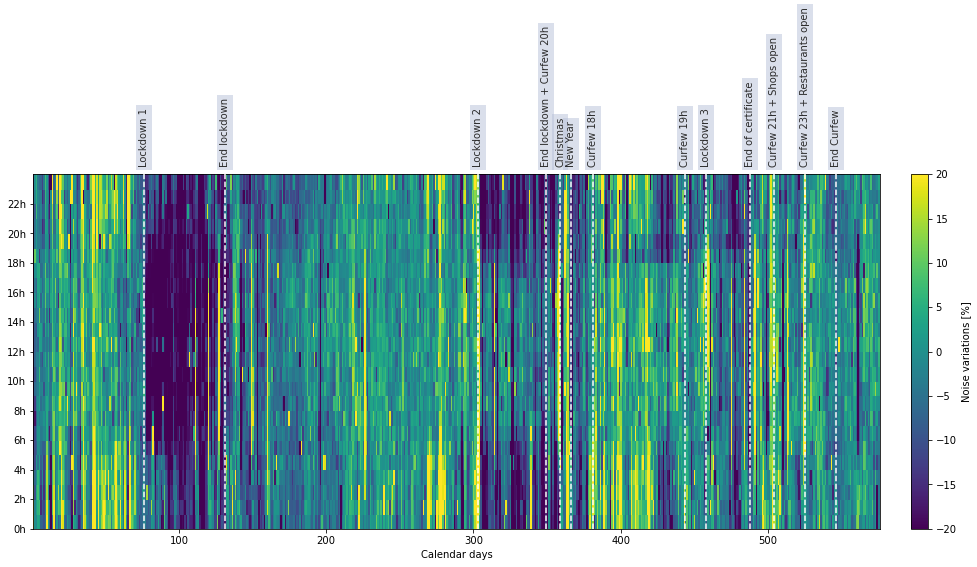

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))

h_mid = np.arange(0, 25, 1)
plt.pcolormesh(dCalendar, h_mid, h_matrix)

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)
    
for n in range(len(dates_tags)):
    delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
    t_search = delta.days
    desc_search = desc_tags[n]
    t_text = t_search
    plt.axvline(t_search, ls="--", lw=1.5, color="white", zorder=10)   # Confinement 1
    plt.text(t_text, 24.5, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
h_label = ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"]
plt.xlabel('Calendar days')
plt.yticks(np.arange(0, 24, 2), h_label)
plt.clim(-20, 20)
plt.colorbar(orientation="vertical", label='Noise variations [%]', pad=0.03)
plt.tight_layout()
# folder = "RESULTS/FR/all_stations/{}Hz/ref2019".format(freq_str)
# if not os.path.exists(folder): os.makedirs(folder)
# plt.savefig("{}/ts_hourvar.png".format(folder), dpi=150)

---
## Comparaisons horaires et journalières

In [15]:
med_values = np.array([])
st_list = []
dCalendar = np.arange(1,577,1)
df = pd.DataFrame(columns=[freq], index=pd.date_range('2019-01-02', '2020-08-01', freq="30min"))
dfcovid = pd.DataFrame(columns=[freq], index=pd.date_range(tStart, tEnd, freq="30min"))

for j, st_str in enumerate(list_stations):       
    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index=pd.to_datetime(dataframe.index)
        dRMS = dataframe
    except:
        continue

    st_list = np.append(st_list, st_str)  

    ### Conversion heures locales
    dRMS = dRMS.copy().tz_localize("UTC").tz_convert("Europe/Brussels").tz_localize(None).resample("30Min").mean()

    ### On garde les données dans la période temporelle qui nous intéresse
    # dRMS de référence (2019)
    mask_ref = (dRMS.index > pd.Timestamp("2019-01-01")) & (dRMS.index <= pd.Timestamp("2020-01-01"))
    dRMS_ref = dRMS.loc[mask_ref]
    submask = (dRMS_ref.index > (tStart - pd.Timedelta("365 days"))) & (dRMS_ref.index <= (tEnd - pd.Timedelta("731 days")))
    dRMS_sub = dRMS_ref.loc[submask]
    dRMS_sub.index = dRMS_sub.index + pd.offsets.DateOffset(years=1)
    dRMS_2019 = pd.concat([dRMS_ref, dRMS_sub])
    dRMS_2019_copy = dRMS_2019.copy()

    # dRMS à comparer (2020-2021)
    mask_time = (dRMS.index > tStart) & (dRMS.index <= tEnd)
    dRMS = dRMS.loc[mask_time]



    ####################################################################################
    ### Calcul des différences 2019 / COVID
    # dRMS_2019 = dRMS_2019[freq].between_time("6:00", "18:00").resample("30min").median()[1:]
    dRMS_2019 = dRMS_2019[freq].resample("30min").median()[1:]
    dRMS_2019 = pd.merge(df,dRMS_2019, how='outer', left_index=True, right_index=True)["{}_y".format(freq)]
    dRMS_2019.name = freq
    
    # dRMS_covid = dRMS[freq].between_time("6:00", "18:00").resample("30min").median()
    dRMS_covid = dRMS[freq].resample("30min").median()
    dRMS_covid = pd.merge(dfcovid,dRMS_covid, how='outer', left_index=True, right_index=True)["{}_y".format(freq)]
    dRMS_covid.name = freq
    
    ### Calage des séries temporelles
    a = dRMS_2019[dRMS_2019.index >= "2019-01-02"] # Premier jour de la liste (2019-01-02) = MERCREDI
    a = a[ (a.index < "2020-01-01") | (a.index >= "2020-01-02") ]  # On retire le 2020-01-01 (qui ici correspond au 2019-01-01) pour
                                                                   # recaler l'année suivante sur la bonne date
    a = a[ (a.index < "2020-02-29") | (a.index >= "2020-03-01") ]  # Retrait du jour férié
    a = a[ a.index < "2020-08-01" ]
    
    b = dRMS_covid[dRMS_covid.index >= "2020-01-01"] # Premier jour de la liste (2020-01-01) = MERCREDI
    b = b[ b.index < "2021-07-29" ]
    
    # print(len(a), len(b))
    data_diff = (np.array(b)-np.array(a))/np.array(a) * 100
    tCalendar = np.arange(0, len(data_diff)/2, 0.5) # Temps en heures à partir du premier point
    
#     noise_2019  = dRMS_2019.tolist()
    
#     ii = 1
#     # Retrait du 01/01/2019 pour se recaler sur un lundi en 2020
#     del noise_2019[364]
#     ii += 1

#     # Retrait du 29 février qui n'existe pas en 2019 pour ne pas être décalé d'un jour calendaire
#     del noise_2019[422]
#     ii += 1

#     noise_2019 = np.asarray(noise_2019)
#     noise_covid = np.asarray(dRMS_covid[:-ii].tolist())
#     # noise_covid = np.asarray(dRMS[freq].resample("1D").median()[:-ii].tolist())
#     dates_diff  = dRMS.resample("1D").median()[:-ii].index
#     data_diff   = (noise_covid-noise_2019)/noise_2019 * 100
    
    if np.isnan(np.nanmedian(data_diff)):
        print('Aucune donnée pour ', st_str)
        continue
       
    if j == 0: med_values = data_diff
    else     : med_values = np.vstack([med_values, data_diff])

Aucune donnée pour  FR.BARI.00.HHZ
Aucune donnée pour  FR.BESN.00.HHZ
Aucune donnée pour  FR.BIMF.00.HHZ
Aucune donnée pour  FR.BOUF.00.HHZ
Aucune donnée pour  FR.BRGF.00.HHZ
Aucune donnée pour  FR.BSCF.00.HHZ
Aucune donnée pour  FR.CHLF.00.HHZ
Aucune donnée pour  FR.CLEV.00.HHZ
Aucune donnée pour  FR.CLF.00.HHZ
Aucune donnée pour  FR.CRNF.00.HHZ
Aucune donnée pour  FR.CURIE.00.HHZ
Aucune donnée pour  FR.FAHY.00.HHZ
Aucune donnée pour  FR.GARF.00.HHZ
Aucune donnée pour  FR.GNEF.00.HHZ
Aucune donnée pour  FR.HELF.00.HHZ
Aucune donnée pour  FR.HRSF.00.HHZ
Aucune donnée pour  FR.OGGL.00.HHZ
Aucune donnée pour  FR.OGJA.00.HHZ
Aucune donnée pour  FR.RESF.00.HHZ
Aucune donnée pour  FR.RUFF.00.HHZ
Aucune donnée pour  FR.SROF.00.HHZ
Aucune donnée pour  FR.VILS.00.HHZ


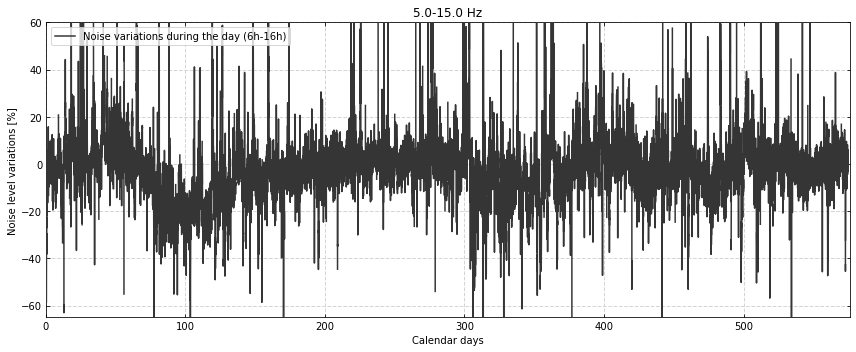

In [16]:
noise_fr = np.nanmedian(med_values, axis=0)
    
color = "#353535"
fig = plt.figure(figsize=(12, 5))
plt.tick_params(direction="in", which="both", top=True, right=True)
plt.plot(tCalendar/24, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations during the day (6h-16h)")
plt.ylim(3.5 * np.nanquantile(noise_fr, 0.05), 5 * np.nanquantile(noise_fr, 0.95))
plt.xlim([0, 576])
plt.xlabel("Calendar days")
plt.ylabel("Noise level variations [%]")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

# for n in range(len(dates_tags)):
#     delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
#     t_search = delta.days
#     desc_search = desc_tags[n]
#     t_text = t_search - 5
#     plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1
#     plt.text(t_text, 1.9*np.nanquantile(data_diff, 0.05), desc_search,
#             color="#2B2B2B", fontsize="medium", rotation=90,
#             ha="center", va="bottom",
#             bbox=box_txt)   # Confinement 1

# med_var = np.zeros(np.shape(med_values))

# for i in range(np.shape(med_var)[0]):
#     sub_list = med_values[i][:]    
#     med_var[i][:] = (sub_list - np.nanmedian(sub_list))/np.nanmedian(sub_list) * 100
    
med_var = med_values.copy()
    
# perc_i = list()  # 5%
# perc_f = list()  # 80%

# for ii in range(np.shape(med_var)[1]):
#     sublist = list()
#     for i in range(np.shape(med_var)[0]):
#         sublist = np.append(sublist, med_var[i][ii])

#     perc_i = np.append(perc_i, np.nanquantile(sublist, 0.1))
#     perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))
    
# plt.fill_between(dCalendar, perc_i, perc_f,alpha=.25, label="percentile 10%-80%", color=color, lw=0)    
plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-65, 60)
plt.legend(loc=2)
plt.title("{} Hz".format(freq_str))
plt.tight_layout()
# folder = "RESULTS/FR/all_stations/{}Hz/ref2019".format(freq_str)
# if not os.path.exists(folder): os.makedirs(folder)
# plt.savefig("{}/ts_day.png".format(folder), dpi=150)
plt.show()

In [17]:
noise = pd.Series(noise_fr, index=b.index)

In [18]:
time, hour, noise_matrix = hourly_var(noise, [[UTCDateTime(tStart), UTCDateTime(tEnd)]])
grid = noise_matrix  # Données en [nm]

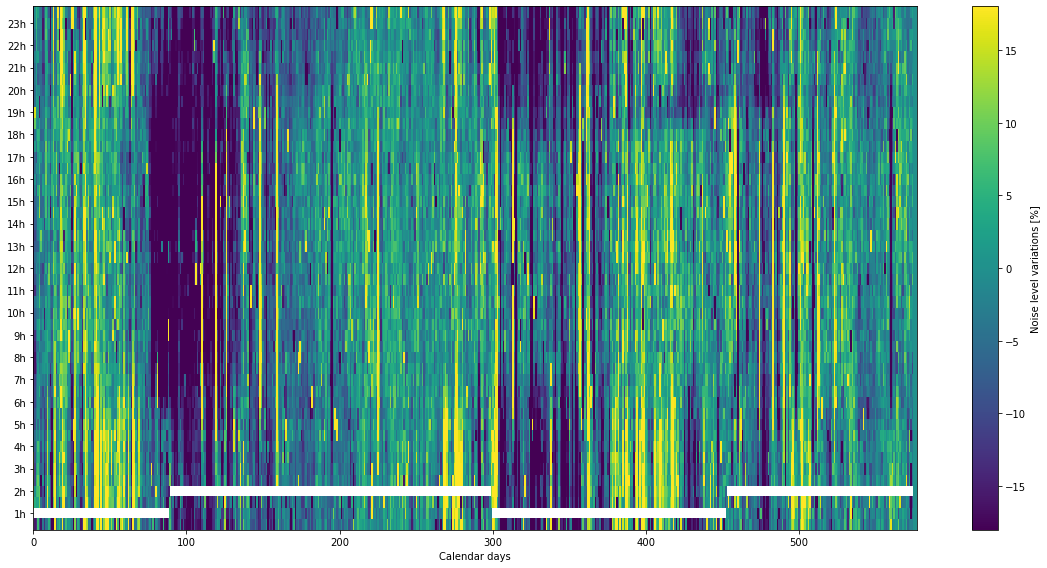

In [66]:
### Mise en graphique de la variation du bruit
plt.figure(figsize=(16, 8))
plt.pcolormesh(np.arange(0, len(time), 1), hour+0.25, grid)
plt.clim(-18, 18)
plt.colorbar(label="Noise level variations [%]")

for n in range(len(dates_tags)):
    delta = dates_tags[n] - pd.Timestamp(2020, 1, 1)
    t_search = delta.days
    desc_search = desc_tags[n]
    t_text = t_search
    plt.axvline(t_search, ls="--", lw=1.5, color="red", zorder=10)   # Confinement 1
    plt.text(t_text, 24.5, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

### Configuration de l'axe vertical
y_ticks = ["%ih" % j for j in range(1, 24)]
y_loc = [j for j in range(1, 24)]
plt.yticks(y_loc, y_ticks)
plt.xlabel('Calendar days')
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz/ref2019".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_hourvar.png".format(folder), dpi=150)
plt.show()

In [20]:
week = [(0, 'Monday'), (1, 'Tuesday'), (2, 'Wednesday'), (3, 'Thursday'), (4, 'Friday'), (5, 'Saturday'), (6, 'Sunday')]

# On détermine les jours de la semaine de tous les jours étudiés
week_count = {'Monday':[], 'Tuesday':[], 'Wednesday':[], 'Thursday':[], 'Friday':[], 'Saturday':[], 'Sunday':[]}

for iDay in range(len(dates)):
    for iw, weekday in week:
        if dates[iDay].dayofweek==iw:
            week_count[weekday].append(iDay)
            
for key in week_count.keys():
    week_count[key] = np.array(week_count[key])

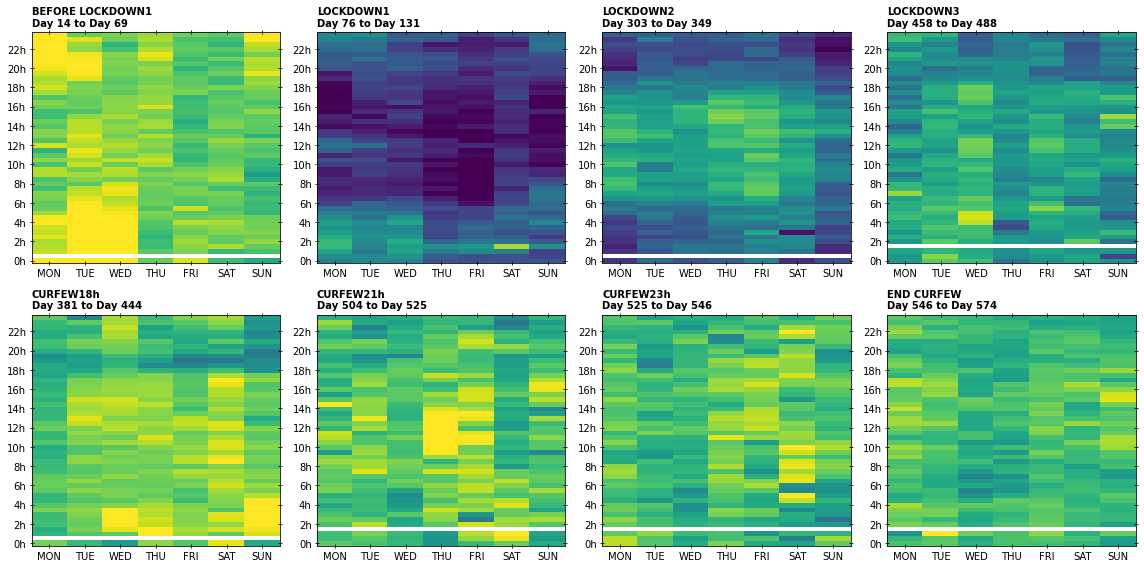

In [21]:
h_matrix = grid

nlines = 2
ncols  = 4
periods = {
    'BEFORE LOCKDOWN1':(pd.to_datetime("2020-01-15"), pd.to_datetime("2020-03-10")),
    'LOCKDOWN1':(pd.to_datetime("2020-03-17"), pd.to_datetime("2020-05-11")),
    'LOCKDOWN2':(pd.to_datetime("2020-10-30"), pd.to_datetime("2020-12-15")),
    'LOCKDOWN3':(pd.to_datetime("2021-04-03"), pd.to_datetime("2021-05-03")),
    'CURFEW18h':(pd.to_datetime("2021-01-16"), pd.to_datetime("2021-03-20")),
    'CURFEW21h':(pd.to_datetime("2021-05-19"), pd.to_datetime("2021-06-09")),
    'CURFEW23h':(pd.to_datetime("2021-06-09"), pd.to_datetime("2021-06-30")),
    'END CURFEW':(pd.to_datetime("2021-06-30"), pd.to_datetime("2021-07-28"))
}

plt.figure(figsize=(4*ncols, 4*nlines))

ss = 1
for desc in periods.keys():
    plt.subplot(nlines, ncols, ss)
    
    plt.tick_params(direction="inout", which="both", top=True, right=True)

    t1 = periods[desc][0]
    t2 = periods[desc][1]

    for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:

        dates_sort = dates[week_count[weekday]]
        dates_sort = dates_sort[dates_sort >= t1]
        dates_sort = dates_sort[dates_sort <= t2]

        k=0
        for d in dates_sort:
            ii = np.where(dates == d)[0][0]
            if k==0: subarray = np.array(h_matrix[:,ii])
            else:    subarray = np.vstack([subarray, h_matrix[:,ii]])
            k += 1

        subarray = np.nanmedian(subarray, axis=0)
        subarray = np.expand_dims(subarray, 1)

        if weekday=='Monday': week_array = subarray
        else:                 week_array = np.append(week_array, subarray, axis=1)
    
    idx1 = np.where(dates == t1)[0][0]
    idx2 = np.where(dates == t2)[0][0]
    plt.title("{}\nDay {} to Day {}".format(desc, idx1, idx2), loc="left", fontweight="bold", fontsize=10)
    plt.pcolormesh(week_array)
    h_label = ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"]
    w_label = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
    plt.yticks(np.arange(0, 48, 4)+0.5, h_label)
    plt.xticks(np.arange(0, 7, 1)+0.5, w_label)
    plt.clim(-25, 10)
    
    ss += 1
    
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz/ref2019".format(freq_str)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/hours_vs_week_periods.png".format(folder), dpi=150)
plt.show()